In [25]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kmedoids import KMedoids
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
import pickle

In [2]:
X = pd.read_csv('../../dataset/processed/normalized_features.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
k2_model = KMedoids(n_clusters=2, metric='euclidean', method='alternate')
k2_model.fit(X_scaled)

final_labels = k2_model.labels_
medoid_indices = k2_model.medoid_indices_
medoids = X_scaled[medoid_indices]

In [5]:
df_engineered = pd.read_csv('../../dataset/processed/normalized_features.csv')
df_meta = pd.read_csv('../../dataset/processed/player_metadata.csv')
df_engineered["Cluster"] = final_labels
df_with_clusters = df_meta.join(df_engineered[["Cluster"]])

In [6]:
df_medoids = df_with_clusters.iloc[medoid_indices].copy()

In [24]:
print("\nRepresentative medoid players per cluster:")
print(df_medoids[["Name", "Club", "Nat", "Age", "CA", "PA", "Cluster"]])

print("\nCluster sizes:")
print(df_engineered["Cluster"].value_counts().sort_index())


Representative medoid players per cluster:
                  Name        Club  Nat  Age   CA   PA  Cluster
61         Xavi Simons  RB Leipzig  NED   20  148  162        0
1027  Gerard Hernàndez  Villarreal  ESP   18   85  131        1

Cluster sizes:
Cluster
0    993
1    828
Name: count, dtype: int64


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

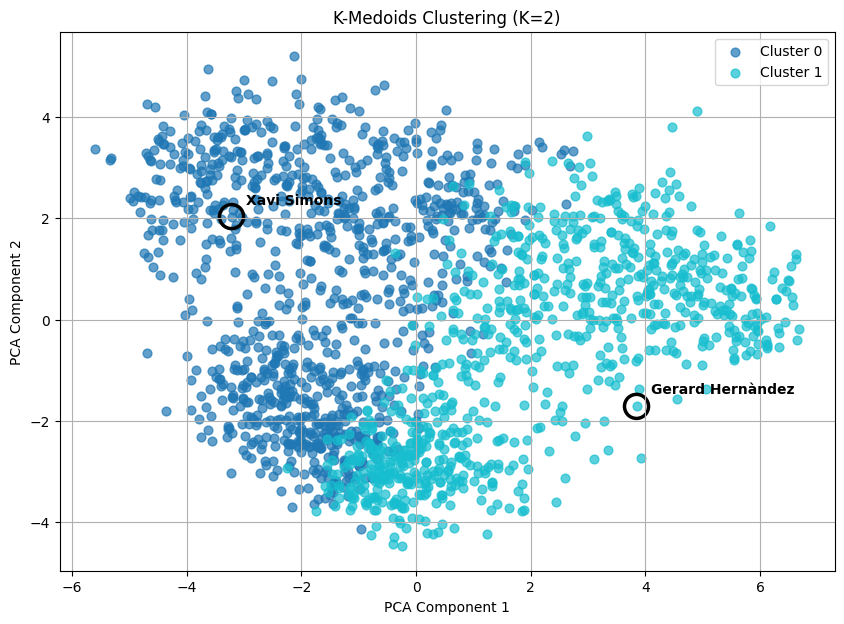

In [23]:
clusters = np.unique(final_labels)

plt.figure(figsize=(10, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    mask = (final_labels == cluster)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        s=40, 
        c=[color], 
        label=f"Cluster {cluster}", 
        alpha=0.70
    )

for i, m in enumerate(medoid_indices):
    plt.scatter(
        X_pca[m, 0], 
        X_pca[m, 1], 
        s=300, 
        edgecolors="black",
        facecolors="none", 
        linewidths=2.5, 
        marker="o"
    )
    # Add player name next to medoid
    name = df_with_clusters.iloc[m]["Name"]
    plt.text(
        X_pca[m, 0]+0.25, 
        X_pca[m, 1]+0.25, 
        name, 
        fontsize=10, 
        fontweight="bold"
    )

plt.title(f'K-Medoids Clustering (K=2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
df_plot = pd.DataFrame({
    "x": X_pca[:, 0],
    "y": X_pca[:, 1],
    "Cluster": final_labels,
    "Name": df_with_clusters["Name"].values,
    "Club": df_with_clusters["Club"].values,
    "CA": df_with_clusters["CA"].values,
    "PA": df_with_clusters["PA"].values,
})

df_plot["is_medoid"] = False
df_plot.loc[medoid_indices, "is_medoid"] = True

fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    color="Cluster",
    hover_data=["Name", "Club", "CA", "PA"],
    title=f"K-Medoids Clustering (K=2) - PCA Projection",
    opacity=0.8,
)

medoids_df = df_plot[df_plot["is_medoid"]]

fig.add_scatter(
    x=medoids_df["x"],
    y=medoids_df["y"],
    mode="markers+text",
    marker=dict(
        size=18,
        symbol="circle-open",
        line=dict(width=2, color="black"),
    ),
    text=medoids_df["Name"],
    textposition="top center",
    hoverinfo="text",
    name="Medoids",
)

fig.update_layout(
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Cluster",
)

fig.show()

In [12]:
for c in df_with_clusters["Cluster"].unique():
    print(f"\n=== Cluster {c}: Top 10 by CA ===")
    display(
        df_with_clusters[df_with_clusters["Cluster"] == c]
        [["Name","Club","CA","PA"]]
        .sort_values("CA", ascending=False)
        .head(10)
    )


=== Cluster 0: Top 10 by CA ===


,Name,Club,CA,PA
0,Harry Kane,FC Bayern,184,185
1,Jude Bellingham,R. Madrid,177,188
2,Joshua Kimmich,FC Bayern,174,183
9,Martin Ødegaard,Arsenal,173,180
5,Luka Modrić,R. Madrid,171,180
7,Bruno Fernandes,Man UFC,171,174
3,Leroy Sané,FC Bayern,169,172
14,İlkay Gündoğan,Barcelona,167,167
27,Bruno Guimarães,Newcastle,165,170
15,Frenkie de Jong,Barcelona,165,181



=== Cluster 1: Top 10 by CA ===


,Name,Club,CA,PA
6,Declan Rice,Arsenal,176,182
8,Eduardo Camavinga,R. Madrid,170,180
11,Federico Valverde,R. Madrid,168,175
31,Reece James,Chelsea,161,170
20,David Alaba,R. Madrid,159,174
16,Casemiro,Man UFC,157,170
18,Leon Goretzka,FC Bayern,157,170
24,Aurélien Tchouameni,R. Madrid,157,177
136,Yves Bissouma,Tottenham,157,165
22,Adrien Rabiot,Juventus,156,159


In [14]:
df_with_clusters.groupby("Cluster")["Age"].mean()

Cluster
0    20.406848
1    20.702899
Name: Age, dtype: float64

In [15]:
df_with_clusters.groupby("Cluster")["PA"].median()

Cluster
0    128.0
1    123.0
Name: PA, dtype: float64

In [16]:
df_with_clusters.groupby("Cluster")["CA"].median()

Cluster
0    85.0
1    80.0
Name: CA, dtype: float64

In [17]:
df_with_clusters.groupby("Cluster")["Name"].count()

Cluster
0    993
1    828
Name: Name, dtype: int64

In [22]:
cols = ['Acc', 'Agi', 'Bal', 'Jum', 'Nat.1', 'Pac', 'Sta', 'Str', 
'Agg', 'Ant', 'Bra', 'Cmp', 'Cnt', 'Dec', 'Det', 'Fla', 
'Ldr', 'OtB', 'Pos', 'Tea', 'Vis', 'Wor', 'Cor', 'Cro', 
'Dri', 'Fin', 'Fir', 'Fre', 'Hea', 'Lon', 
'L Th', 'Mar', 'Pas', 'Pen', 'Tck', 'Tec']
df_engineered.groupby("Cluster")[cols].mean()

,Acc,Agi,Bal,Jum,Nat.1,Pac,Sta,Str,Agg,Ant,...,Fir,Fre,Hea,Lon,L Th,Mar,Pas,Pen,Tck,Tec
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.756643,0.712631,-0.089561,-0.717812,0.794884,0.653930,0.278048,-0.813133,0.243979,-0.075438,...,0.951709,-0.343767,-1.092444,0.007535,-1.804190,-0.973687,0.820474,-0.688959,-0.439792,0.961924
1,0.524198,0.413476,0.162992,0.068407,1.076175,0.542784,0.380879,-0.128801,0.682650,0.139275,...,0.602863,-1.071036,-0.377366,-0.373225,-1.494453,-0.056657,0.672140,-1.264562,0.687674,0.387086


In [26]:
with open("../../models/kmedoids_k2_model.pkl", "wb") as f:
    pickle.dump(k2_model, f)